<span style="font-family:Papyrus; font-size:2.5em;">Generative Adversarial Networks (GANs)</span>
---
![](https://espresso-jobs.com/conseils-carriere/wp-content/uploads/2019/05/monalisa.gif)
<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

- Generative Adversarial Networks (GANs)
- How GANs Work
- GANs Process
- Examples




**Importing the libraries**

In [2]:
from __future__ import print_function
from time import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
import os
from torch.autograd import Variable

print('librerías importadas')

librerías importadas


In [ ]:
# NO ejecutar en colab
!ls /kaggle/input

There are 768 chairs .
Maximo:  255 Minimo:  4


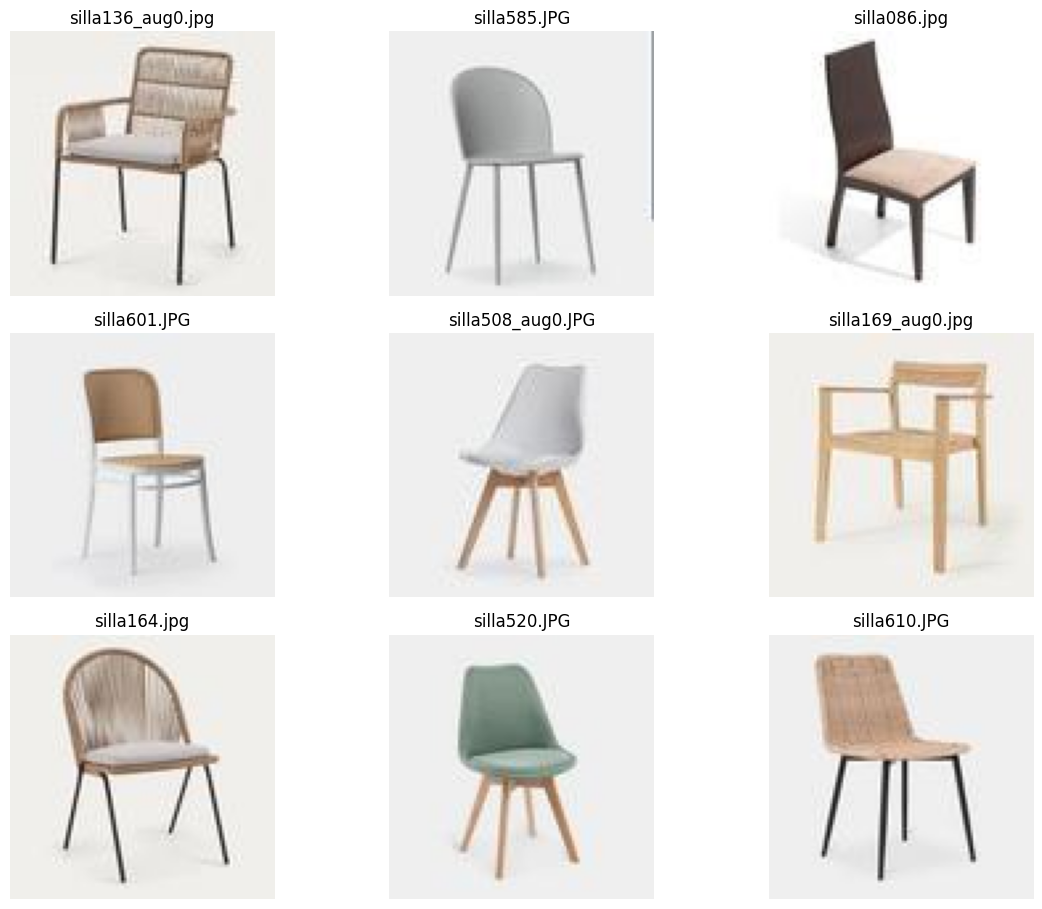

In [3]:
# FOLDER = '/kaggle/input/'
# CLASS = 'antic-chairs/antic_chairs/'
# PATH =  '/kaggle/input/antic-chairs/antic_chairs/'

# FOLDER = '/content/drive/MyDrive/ColabNotebooks/datasets/'
# CLASS = 'chairs/antic_chairs/'
# PATH = '/content/drive/MyDrive/ColabNotebooks/datasets/chairs/antic_chairs/'

# FOLDER = '/content/drive/MyDrive/ColabNotebooks/dataset2/'
# CLASS = 'sillas/sillas_100Max/'
# PATH = '/content/drive/MyDrive/ColabNotebooks/dataset2/sillas/sillas_100Max/'

FOLDER = '/content/drive/MyDrive/ColabNotebooks/dataset3/'
CLASS = 'sillas/sillas_100ext_aum/'
PATH = '/content/drive/MyDrive/ColabNotebooks/dataset3/sillas/sillas_100ext_aum/'

BASE_SAVE_PATH = '/content/drive/MyDrive/ColabNotebooks/results/'
TEST_SAVE_PATH = '/content/drive/MyDrive/ColabNotebooks/test_generated_images/'


images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} chairs .')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

print('Maximo: ', np.max(img), 'Minimo: ', np.min(img))

# Image Preprocessing


**Initial code ...**

```
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('../input/all-dogs/', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

```

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
batch_size = 32
image_size = 64
latent_dim = 100
ngf = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_noresize = transforms.Compose([transforms.Resize(64),
                                        #transforms.CenterCrop(64),
                                         transforms.ToTensor()])

train_data = datasets.ImageFolder(FOLDER, transform=transform)
train_loader = DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

train_data_noresize = datasets.ImageFolder(FOLDER, transform=transform_noresize)
train_loader_noresize = DataLoader(train_data_noresize, shuffle=True,
                                           batch_size=batch_size)

(32, 64, 64, 3)


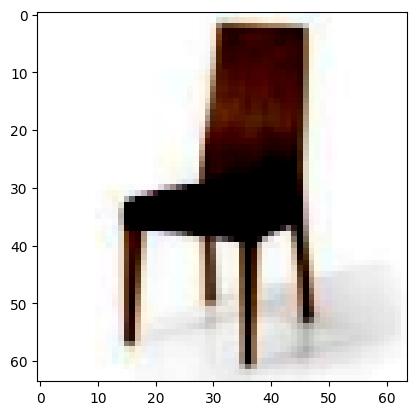

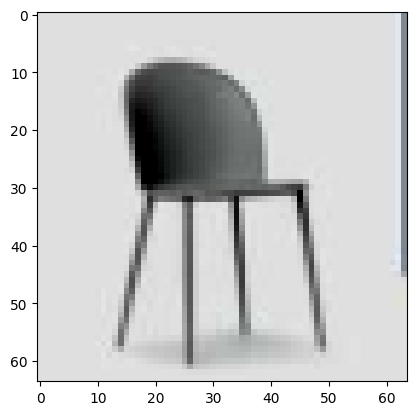

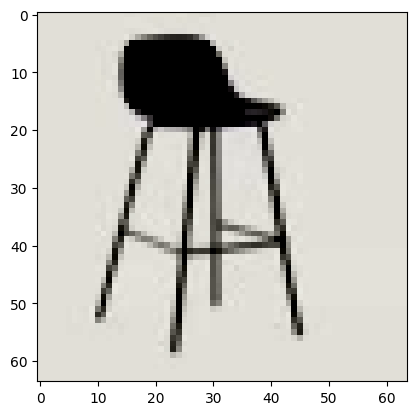

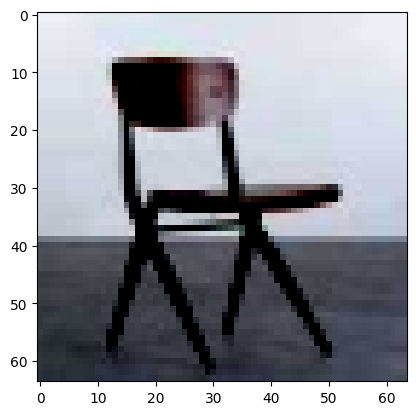

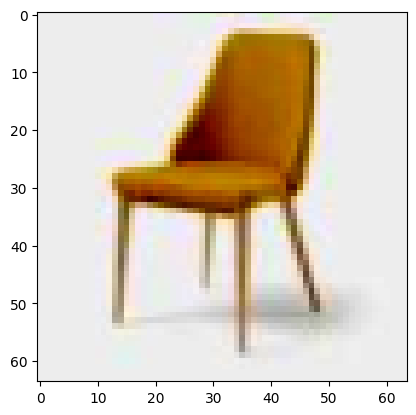

(32, 64, 64, 3)


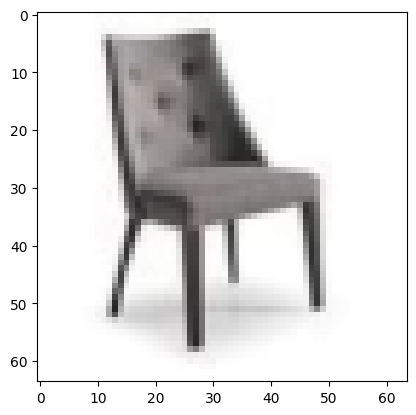

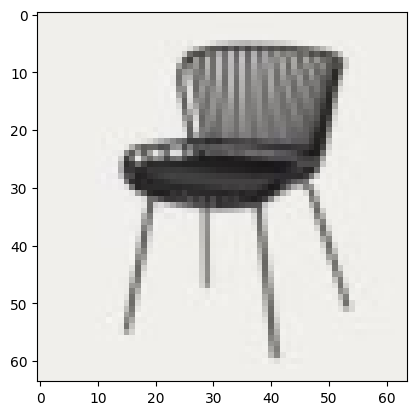

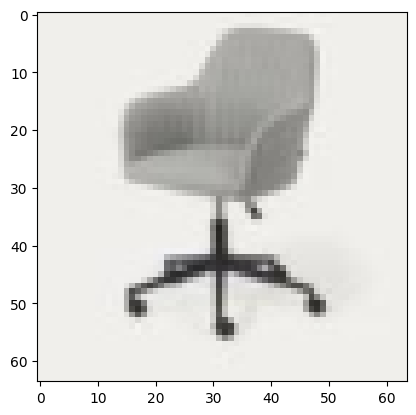

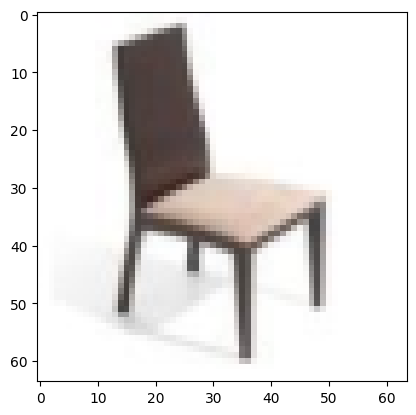

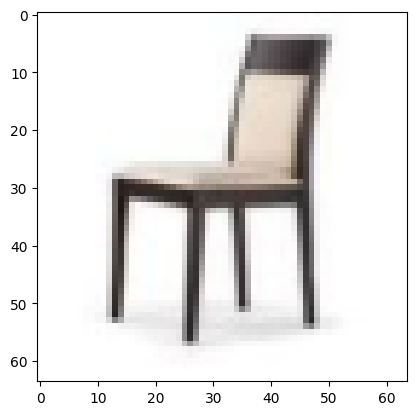

In [6]:
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

imgs_noresize, label_noresize = next(iter(train_loader_noresize))
imgs_noresize = imgs_noresize.numpy().transpose(0, 2, 3, 1)

print(imgs.shape)
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

print(imgs_noresize.shape)
for i in range(5):
    plt.imshow(imgs_noresize[i])
    plt.show()

# Weights
### Defining the weights_init function

In [7]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [ ]:
# OJO! GENERADOR NUEVO EN EL SIGUIENTE BLOQUE DE CÓDIGO

class G(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(G, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(latent_dim, 512, 4, stride=2, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Sigmoid()
                )

    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G().to(device)
netG.apply(weights_init)

In [ ]:
# NUEVO GENERADOR!!!
# OTRO GENERADOR MÁS EN EL SIGUIENTE BLOQUE

#GENERADOR 2 CON NÚMERO DE FILTRO MODIFICABLE

class G(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(G, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(latent_dim, ngf, 4, stride=2, padding=0, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf, ngf // 2, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf // 2),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf // 2, ngf // 4, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf // 4),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf//4, ngf // 8, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf // 8),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf // 8, 3, 4, stride=2, padding=1, bias=False),
                nn.Sigmoid()
                )

    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G().to(device)
netG.apply(weights_init)



In [8]:
#GENERADOR 3 CON NÚMERO DE FILTRO MODIFICABLE BUEN RESULTADO

latent_dim = 100
ngf = 128

class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            #1 (Initial projection from latent_dim to spatial features)
            # Input: (batch_size, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Output: (batch_size, ngf * 8, 4, 4)

            #2
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Output: (batch_size, ngf * 4, 8, 8)

            #3
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Output: (batch_size, ngf * 2, 16, 16)

            #4
            nn.ConvTranspose2d(ngf * 2, ngf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output: (batch_size, ngf, 32, 32)

            #5 (Final layer for 64x64 output)
            nn.ConvTranspose2d(ngf, 3, 4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
            # Output: (batch_size, 3, 64, 64)
        )

    def forward(self, input):
        return self.main(input)

# Example of use:
# latent_dim = 100  # Dimension of the latent vector
# ngf = 64          # Base number of generator filters (commonly 64)
#
# netG = G(latent_dim, ngf)
# dummy_input = torch.randn(1, latent_dim, 1, 1) # Batch size of 1, 1x1 spatial input
# output = netG(dummy_input)
# print(output.shape) # This should now print torch.Size([1, 3, 64, 64])
    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G().to(device)
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [8]:
# GENERADOR 4 ESTE SI INCORPORA UNA CAPA MÁS (6 EN TOTAL)

latent_dim = 100
ngf = 64
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            # 1: Latent_dim -> 4x4 (channels: ngf*16)
            # Input: (batch_size, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, ngf * 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # Output: (batch_size, ngf * 16, 4, 4)

            # 2: 4x4 -> 8x8 (channels: ngf*8)
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Output: (batch_size, ngf * 8, 8, 8)

            # 3: 8x8 -> 16x16 (channels: ngf*4)
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Output: (batch_size, ngf * 4, 16, 16)

            # 4: 16x16 -> 32x32 (channels: ngf*2)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Output: (batch_size, ngf * 2, 32, 32)

            # 5: 32x32 -> 64x64 (channels: ngf)  --- This is the layer that generates the 64x64 feature map
            nn.ConvTranspose2d(ngf * 2, ngf, 4, stride=2, padding=1, bias=False), # (32-1)*2 - 2*1 + 4 = 62-2+4 = 64
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output: (batch_size, ngf, 64, 64)

            # 6: 64x64 -> 64x64 RGB (channels: 3) --- This layer changes only channels, not spatial size
            nn.ConvTranspose2d(ngf, 3, 1, stride=1, padding=0, bias=False), # kernel_size=1, stride=1, padding=0 is like 1x1 conv
            nn.Sigmoid()
            # Calculation: (64 - 1) * 1 - 2 * 0 + 1 = 63 - 0 + 1 = 64
            # Output: (batch_size, 3, 64, 64)
        )


    def forward(self, input):
        return self.main(input)

# Ejemplo de uso:
# latent_dim = 100
# ngf = 64

# netG = G(latent_dim, ngf)
# dummy_input = torch.randn(1, latent_dim, 1, 1)
# output = netG(dummy_input)
# print(f"Output shape: {output.shape}")
# assert output.shape == (1, 3, 64, 64), "Output shape is not 64x64 RGB!"

def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G().to(device)
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2

# Discriminator

In [9]:
# Defining the discriminator
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=1, padding=1, bias=False),
                nn.MaxPool2d(2,2),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Conv2d(64, 128, 4, stride=1, padding=1, bias=False),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Conv2d(128, 256, 4, stride=1, padding=1, bias=False),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Conv2d(256, 512, 4, stride=1, padding=1, bias=False),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Flatten(),
                nn.Linear(4608,100),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Linear(100,1),
                nn.Sigmoid()
                )

    def forward(self, input):
        output = self.main(input)
        # .view(-1) = Flattens the output into 1D instead of 2D
        return output.view(-1)


# Creating the discriminator
netD = D().to(device)
netD.apply(weights_init)


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout(p=0.3, inplace=False)


# Training

**My training baseline**

In [ ]:
# NO ejecutar en colab
!mkdir results
!ls

In [10]:
LR = 0.0002
# Otra posibilidad
LR_G = 0.0002
LR_D = 0.0002

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(0.5, 0.999))


**ENTRENADOR EXPERIMENTAL**

[0/600] Loss_D: 1.6764; Loss_G: 1.0090
[1/600] Loss_D: 1.2012; Loss_G: 0.8184
[2/600] Loss_D: 1.2808; Loss_G: 0.8926
[3/600] Loss_D: 0.9513; Loss_G: 2.2303
[4/600] Loss_D: 0.5754; Loss_G: 0.6857
[5/600] Loss_D: 0.7166; Loss_G: 2.0039
[6/600] Loss_D: 0.5665; Loss_G: 1.1907
[7/600] Loss_D: 0.5999; Loss_G: 1.9985
[8/600] Loss_D: 0.7674; Loss_G: 3.0079
[9/600] Loss_D: 0.6517; Loss_G: 2.8561
[10/600] Loss_D: 1.5657; Loss_G: 3.1558
[11/600] Loss_D: 0.5812; Loss_G: 2.9524
[12/600] Loss_D: 0.5678; Loss_G: 2.3943
[13/600] Loss_D: 0.5831; Loss_G: 2.3375
[14/600] Loss_D: 0.6500; Loss_G: 2.0365
[15/600] Loss_D: 0.9436; Loss_G: 1.1263
[16/600] Loss_D: 0.7245; Loss_G: 1.2741
[17/600] Loss_D: 0.3842; Loss_G: 2.2946
[18/600] Loss_D: 0.7513; Loss_G: 2.1741
[19/600] Loss_D: 0.5026; Loss_G: 2.3567
[20/600] Loss_D: 0.4699; Loss_G: 3.1440
[21/600] Loss_D: 0.5344; Loss_G: 2.6866
[22/600] Loss_D: 1.3579; Loss_G: 1.6747
[23/600] Loss_D: 0.5373; Loss_G: 2.1627
[24/600] Loss_D: 0.3899; Loss_G: 3.7264
[25/600] L

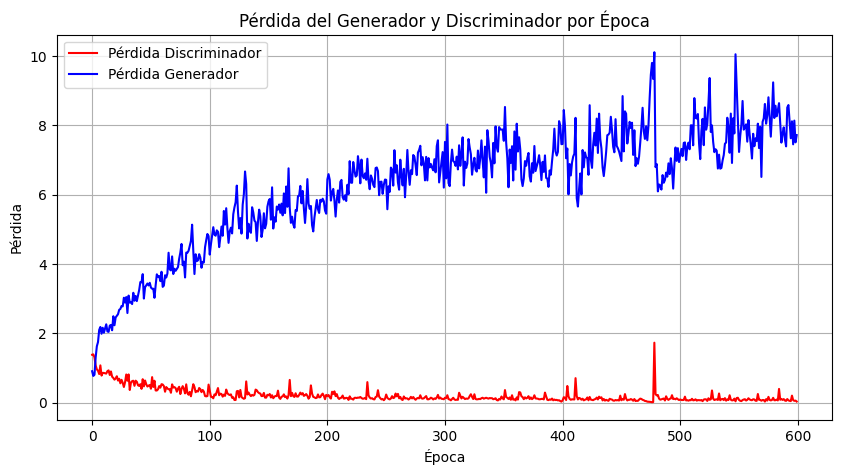

  0%|          | 0/1 [00:00<?, ?it/s]

Imagen 00000 - Discriminador: 0.0192
Imagen 00001 - Discriminador: 0.0089
Imagen 00002 - Discriminador: 0.0244
Imagen 00003 - Discriminador: 0.0002
Imagen 00004 - Discriminador: 0.0001
Imagen 00005 - Discriminador: 0.0437
Imagen 00006 - Discriminador: 0.0597
Imagen 00007 - Discriminador: 0.0831
Imagen 00008 - Discriminador: 0.0009
Imagen 00009 - Discriminador: 0.0003
Imagen 00010 - Discriminador: 0.0123
Imagen 00011 - Discriminador: 0.0000
Imagen 00012 - Discriminador: 0.0036
Imagen 00013 - Discriminador: 0.0000
Imagen 00014 - Discriminador: 0.0616
Imagen 00015 - Discriminador: 0.0127
Imagen 00016 - Discriminador: 0.0001
Imagen 00017 - Discriminador: 0.2781
Imagen 00018 - Discriminador: 0.0014
Imagen 00019 - Discriminador: 0.1616
Imagen 00020 - Discriminador: 0.2208
Imagen 00021 - Discriminador: 0.0019
Imagen 00022 - Discriminador: 0.0010
Imagen 00023 - Discriminador: 0.0691
Imagen 00024 - Discriminador: 0.0048
Imagen 00025 - Discriminador: 0.0003
Imagen 00026 - Discriminador: 0.1058
I

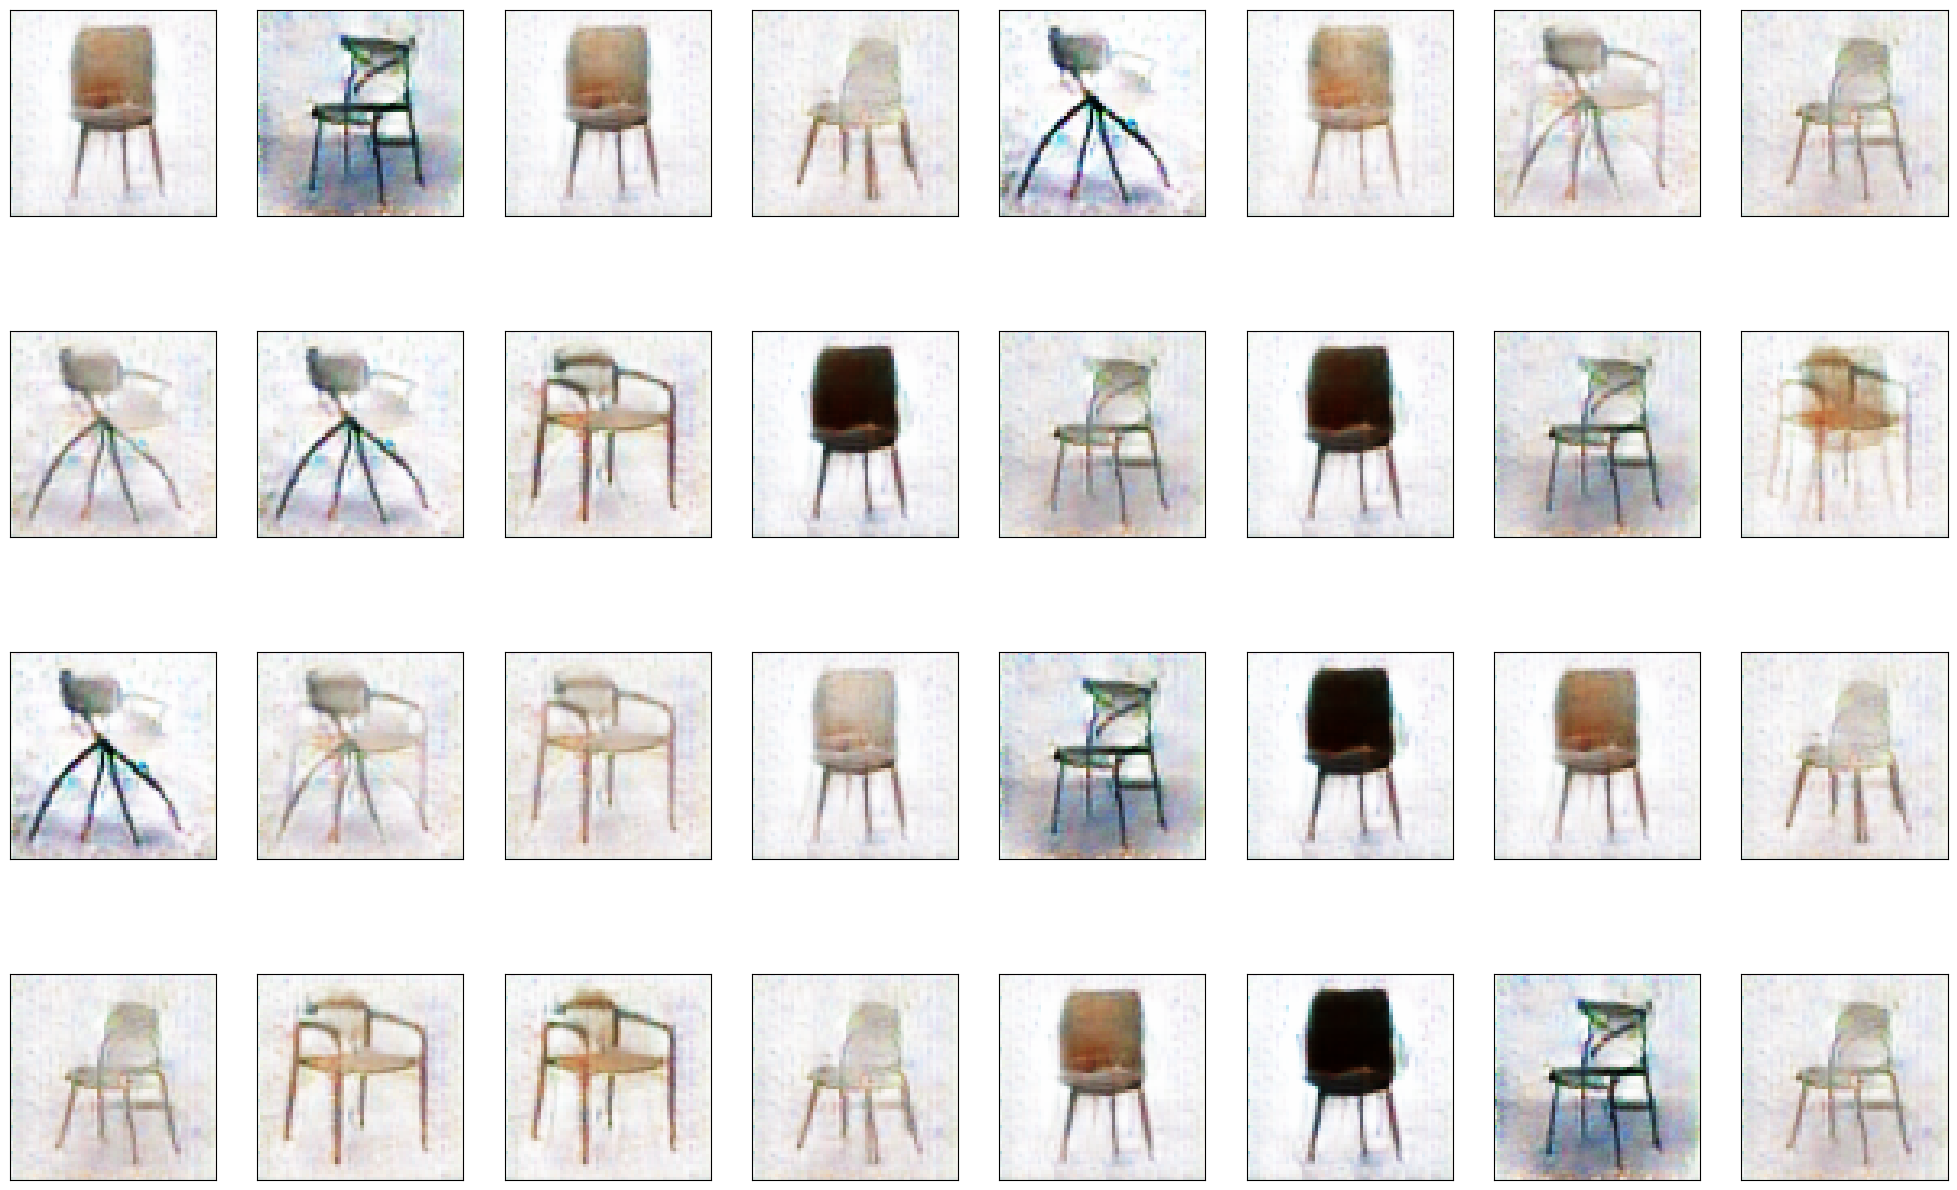

In [11]:
# Datos reducidos a 64x64
# data_loader = train_loader
# Datos originales no normalizados
data_loader = train_loader_noresize

EPOCH = 600 # play with me

losses_D = []
losses_G = []

t0 = time()
for epoch in range(EPOCH):
    epoch_loss_D = 0
    epoch_loss_G = 0
    num_batches = 0
    for i, data in enumerate(data_loader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad()

        # Training the discriminator with a real image of the dataset
        input,_ = data
        input = input.to(device)
        target = torch.ones(input.size()[0]).to(device)
        output = netD(input)
        errD_real = criterion(output, target)

        # Training the discriminator with a fake image generated by the generator
        noise = torch.randn(input.size()[0], 100, 1, 1).to(device)
        fake = netG(noise)
        target = torch.zeros(input.size()[0]).to(device)
        output = netD(fake.detach())
        errD_fake = criterion(output, target)

        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator
        noise = torch.randn(input.size()[0], 100, 1, 1).to(device)
        fake = netG(noise)
        netG.zero_grad()
        target = torch.ones(input.size()[0]).to(device)
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()

        # 3nd Step: SECOND Updating the weights of the neural network of the generator
        noise = torch.randn(input.size()[0], 100, 1, 1).to(device)
        fake = netG(noise)
        netG.zero_grad()
        target = torch.ones(input.size()[0]).to(device)
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()

        # Acumular pérdidas
        epoch_loss_D += errD.item()
        epoch_loss_G += errG.item()
        num_batches += 1

    losses_D.append(epoch_loss_D / num_batches)
    losses_G.append(epoch_loss_G / num_batches)

    # 3rd Step: Printing the losses and saving the real images and the generated images of the last minibatch
    print('[%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, errD.item(), errG.item()))
    save_image(input, os.path.join(BASE_SAVE_PATH, 'real_samples.png'), normalize=True)
    save_image(fake.data, os.path.join(BASE_SAVE_PATH, 'fake_samples_epoch_%03d.png' % epoch), normalize=True)
tf = time()
print(tf - t0)

# Salvar si nos ha gustado el resultado
best_model_g = os.path.join(BASE_SAVE_PATH, 'generator_v2.pth')
best_model_d = os.path.join(BASE_SAVE_PATH, 'discriminator_v2.pth')
torch.save(netG.state_dict(), best_model_g)
torch.save(netD.state_dict(), best_model_d)

# generar y guardar gráfica de pérdidas
plt.figure(figsize=(10, 5))
plt.plot(range(EPOCH), losses_D, label='Pérdida Discriminador', color='red')
plt.plot(range(EPOCH), losses_G, label='Pérdida Generador', color='blue')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida del Generador y Discriminador por Época')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_SAVE_PATH, 'loss_plot.png')) # Guarda la gráfica
plt.show()

# Generar lote de imágenes

if not os.path.exists(TEST_SAVE_PATH):
    os.makedirs(TEST_SAVE_PATH)
    print(f"Carpeta de imágenes generadas creada en: {TEST_SAVE_PATH}")

im_batch_size = 50
n_images=10

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
with torch.no_grad():
    outputs = netD(gen_images)
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join(TEST_SAVE_PATH, f'image_{i_batch+i_image:05d}.png'))

for i_image in range(gen_images.size(0)):
        score = outputs[i_image].item()
        print(f'Imagen {i_batch + i_image:05d} - Discriminador: {score:.4f}')
        save_image(gen_images[i_image, :, :, :], os.path.join(TEST_SAVE_PATH, f'image_{i_batch+i_image:05d}.png'))

fig = plt.figure(figsize=(25, 16))

# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

**ENTRENADOR COMPROBADO**

In [ ]:
# Datos reducidos a 64x64
# data_loader = train_loader
# Datos originales no normalizados
data_loader = train_loader_noresize

EPOCH = 300 # play with me

losses_D = []
losses_G = []

t0 = time()
for epoch in range(EPOCH):
    epoch_loss_D = 0
    epoch_loss_G = 0
    num_batches = 0
    for i, data in enumerate(data_loader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad()

        # Training the discriminator with a real image of the dataset
        input,_ = data
        input = input.to(device)
        target = torch.ones(input.size()[0]).to(device)
        output = netD(input)
        errD_real = criterion(output, target)

        # Training the discriminator with a fake image generated by the generator
        noise = torch.randn(input.size()[0], 100, 1, 1).to(device)
        fake = netG(noise)
        target = torch.zeros(input.size()[0]).to(device)
        output = netD(fake.detach())
        errD_fake = criterion(output, target)

        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator
        netG.zero_grad()
        target = torch.ones(input.size()[0]).to(device)
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        # Acumular pérdidas
        epoch_loss_D += errD.item()
        epoch_loss_G += errG.item()
        num_batches += 1

    losses_D.append(epoch_loss_D / num_batches)
    losses_G.append(epoch_loss_G / num_batches)

    # 3rd Step: Printing the losses and saving the real images and the generated images of the last minibatch
    print('[%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, errD.item(), errG.item()))
    save_image(input, os.path.join(BASE_SAVE_PATH, 'real_samples.png'), normalize=True)
    save_image(fake.data, os.path.join(BASE_SAVE_PATH, 'fake_samples_epoch_%03d.png' % epoch), normalize=True)
tf = time()
print(tf - t0)

# Salvar si nos ha gustado el resultado
best_model_g = os.path.join(BASE_SAVE_PATH, 'generator_v2.pth')
best_model_d = os.path.join(BASE_SAVE_PATH, 'discriminator_v2.pth')
torch.save(netG.state_dict(), best_model_g)
torch.save(netD.state_dict(), best_model_d)

# generar y guardar gráfica de pérdidas
plt.figure(figsize=(10, 5))
plt.plot(range(EPOCH), losses_D, label='Perdida Discriminador', color='red')
plt.plot(range(EPOCH), losses_G, label='Perdida Generador', color='blue')
plt.xlabel('Época')
plt.ylabel('Perdida')
plt.title('Perdida del Generador y Discriminador por Época')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_SAVE_PATH, 'loss_plot.png')) # Guarda la gráfica
plt.show()

# Generar lote de imágenes

if not os.path.exists(TEST_SAVE_PATH):
    os.makedirs(TEST_SAVE_PATH)
    print(f"Carpeta de imágenes generadas creada en: {TEST_SAVE_PATH}")

im_batch_size = 50
n_images=10

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
with torch.no_grad():
    outputs = netD(gen_images)
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join(TEST_SAVE_PATH, f'image_{i_batch+i_image:05d}.png'))

for i_image in range(gen_images.size(0)):
        score = outputs[i_image].item()
        print(f'Imagen {i_batch + i_image:05d} - Discriminador: {score:.4f}')
        save_image(gen_images[i_image, :, :, :], os.path.join(TEST_SAVE_PATH, f'image_{i_batch+i_image:05d}.png'))

fig = plt.figure(figsize=(25, 16))

# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

# Salvar pesos

In [ ]:
# Salvar si nos ha gustado el resultado
best_model_g = os.path.join(BASE_SAVE_PATH, 'generator_v1.pth') # Puedes usar el mismo BASE_SAVE_PATH
best_model_d = os.path.join(BASE_SAVE_PATH, 'discriminator_v1.pth') # Puedes usar el mismo BASE_SAVE_PATH
torch.save(netG.state_dict(), best_model_g)
torch.save(netD.state_dict(), best_model_d)

# Recuperar pesos

In [11]:
# Recuperar
RECOVER_PATH = '/content/drive/MyDrive/ColabNotebooks/ALMACEN/entrenamiento42/' # O la ruta donde los guardaste
best_model_g = os.path.join(RECOVER_PATH, 'generator_42.pth') # O el nombre del archivo que quieres cargar
best_model_d = os.path.join(RECOVER_PATH, 'discriminator_42.pth') # O el nombre del archivo que quieres cargar

if os.path.exists(best_model_g) and os.path.exists(best_model_d):
    netG.load_state_dict(torch.load(best_model_g, map_location=device)) # Añade map_location=device si es necesario
    netD.load_state_dict(torch.load(best_model_d, map_location=device)) # Añade map_location=device si es necesario
    print("Modelos cargados exitosamente desde Drive.")

# netG.load_state_dict(torch.load(best_model_g, weights_only=True))
# netD.load_state_dict(torch.load(best_model_d, weights_only=True))

Modelos cargados exitosamente desde Drive.


# Lo que sigue está sin revisar

# Best public training
- 06/29 [RaLSGAN dogs](https://www.kaggle.com/speedwagon/ralsgan-dogs) V9
- 06/29 this kernel V5
- some version of this kernel

In [ ]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

**Show generated images**
> show_generated_img()

In [ ]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)

    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)

    plt.show()
    plt.close()

In [ ]:
nz=100
show_generated_img()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(EPOCH), losses_D, label='Perdida Discriminador', color='red')
plt.plot(range(EPOCH), losses_G, label='Perdida Generador', color='blue')
plt.xlabel('Época')
plt.ylabel('Perdida')
plt.title('Perdida del Generador y Discriminador por Época')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_SAVE_PATH, 'loss_plot.png'))  # Guarda la gráfica
plt.show()

### Training Loop

# Generation example

In [ ]:
if not os.path.exists('./test'):
    os.mkdir('./test')

im_batch_size = 50
n_images=10

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
with torch.no_grad():
    outputs = netD(gen_images)
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('./test', f'image_{i_batch+i_image:05d}.png'))


In [ ]:
    for i_image in range(gen_images.size(0)):
        score = outputs[i_image].item()
        print(f'Imagen {i_batch + i_image:05d} - Discriminador: {score:.4f}')
        save_image(gen_images[i_image, :, :, :], os.path.join('./test', f'image_{i_batch+i_image:05d}.png'))


In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [ ]:
# Generar lote de imágenes

if not os.path.exists(TEST_SAVE_PATH):
    os.makedirs(TEST_SAVE_PATH)
    print(f"Carpeta de imágenes generadas creada en: {TEST_SAVE_PATH}")

im_batch_size = 50
n_images=10

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
with torch.no_grad():
    outputs = netD(gen_images)
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join(TEST_SAVE_PATH, f'image_{i_batch+i_image:05d}.png'))

for i_image in range(gen_images.size(0)):
        score = outputs[i_image].item()
        print(f'Imagen {i_batch + i_image:05d} - Discriminador: {score:.4f}')
        save_image(gen_images[i_image, :, :, :], os.path.join(TEST_SAVE_PATH, f'image_{i_batch+i_image:05d}.png'))

fig = plt.figure(figsize=(25, 16))

# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Al ejecutar esta celda, se te pedirá que autorices a Google Colab para acceder a tu Google Drive. Sigue las instrucciones para completar la autenticación.